# Experiments with noisy fitness
The accuracy of a neural network does not increase monotonously when training it. This can make it problematic to search for the best architecture while training as it is difficult to separate the trend from the noise.

This notebook has a couple of experiments on what the impact might be for a genetic algorithm searching for good models as they are being trained. It also investigates a few mitigations. 

In order to make experiments feasible to conduct, a very simplified model is used where no neural networks are actually being trained. Instead, candidates are only defined by their final accuracy, how quickly they will reach it and how noisy the training is.

In [1]:
using FitnessNoise
using Plots
pyplot();

┌ Warning: Incompatibility detected between CUDA and LLVM 8.0+; disabling debug info emission for CUDA kernels
└ @ CUDAnative E:\Programs\julia\.julia\packages\CUDAnative\hfulr\src\CUDAnative.jl:114
┌ Info: Precompiling FitnessNoise [379b1e52-9345-5b9d-80ab-b5c69e69a413]
└ @ Base loading.jl:1260


This is an example of how the accuracy improves with training for four different candidates.

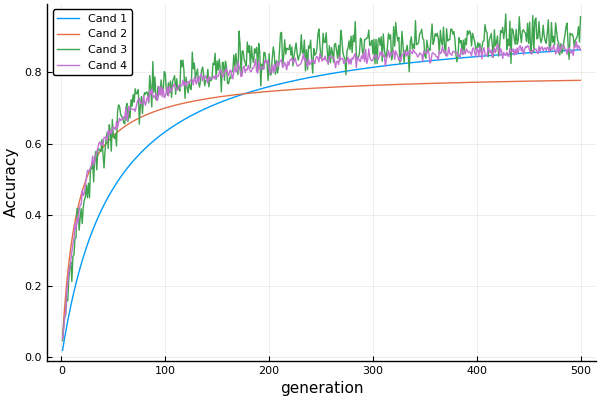

In [2]:
# Good accuracy (95%) but slow
cand1 = Cand(0.95, 0.02, 0.0);
# Worse accuracy (80%) but fast
cand2 = Cand(0.80, 0.07, 0.0);
# Good accuracy (95%), and noisy
cand3 = Cand(0.95, 0.04, 0.03);
# Decent accuracy (90%) and noisy
cand4 = Cand(0.9, 0.05, 0.01);

# Lets "train" them
function train(cand)
    accuracy = []
    for i in 1:500
        push!(accuracy, fitness(cand))
        cand = FitnessNoise.nextgen(cand)
    end
    return accuracy
end

plt = plot(xlabel="generation", ylabel="Accuracy");
plot!(plt, train(cand1), label="Cand 1");
plot!(plt, train(cand2), label="Cand 2");
plot!(plt, train(cand3), label="Cand 3");
plot!(plt, train(cand4), label="Cand 4");
plt

Mutation randomly changes the final accuracy, the speed and the noise variance

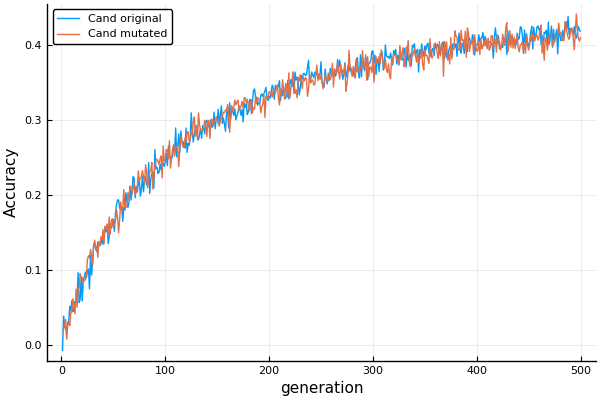

In [3]:
cando = Cand(0.5, 0.01, 0.01)
candm = FitnessNoise.mutate(cando)

plt = plot(xlabel="generation", ylabel="Accuracy");
plot!(plt, train(cando), label="Cand original");
plot!(plt, train(candm), label="Cand mutated");
plt

Lets see what happens if we search a population for the best candidate when there is no noise in the accuracy:

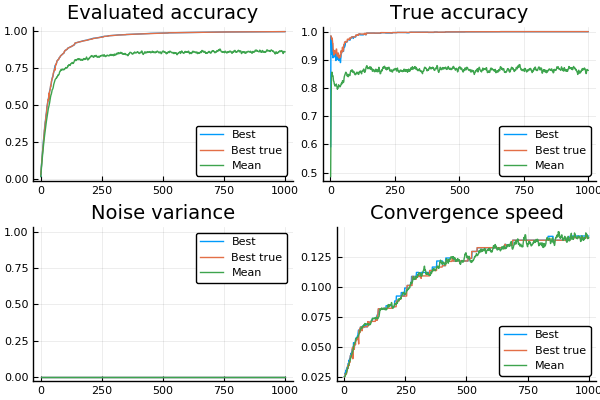

In [4]:
population_size = 128
num_generations = 1000
seed = 1234
uniform(mean, std) = mean * (1 + std * rand() - 0.5)
ga(population_size, num_generations, seed, cfun=() -> Cand(rand(), uniform(0.05, 0.01), uniform(0.0, 0.0)))

Ok, that went pretty well. 

The curve labeled "Best" is the value for the best candidate found while "Best true" is the value for the best accuracy after model has been trained to convergence and "Mean" is the average over the whole population. 

As one can see from the plot titled "True accuracy", candidates with a potentially very good accuracy were discarded early on but the genetic algorithm soon found candidates with very good fitness and convergence speed. This is most likely due to the highest accuracy early candidates having too slow convergence speed, compare the speed of "Best true" vs the average in the speed plot. 

Lets see what happens when the noise model is applied.

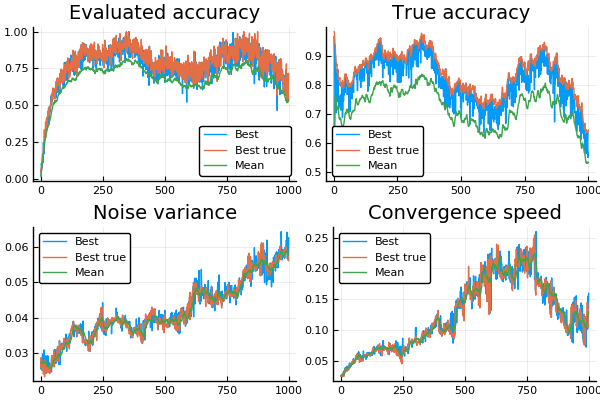

In [5]:
# CacheCand is just to make sure we don't draw a new noise sample every time fitness is called, e.g when sorting
cc = FitnessNoise.CacheCand
candbase() = Cand(rand(), uniform(0.05, 0.01), uniform(0.05, 0.1))
ga(population_size, num_generations, seed, cfun=() -> cc(candbase()))

The noise had a quite detrimental effect on the fitness. It seems like it is a much more attractive strategy to increase the overall noisyness of the population than it is to search for truly good candidates.

A standard mitigation for noise is averaging. One recommendation in the litterature is to just evalute the fitness multiple times and use the average. This strategy can't be applied directly to the neural architecture search method used in NaiveGAflux since the fitness is deterministic for a model and only changes when training.

Lets anyways see if it is an applicable strategy for this simple problem:

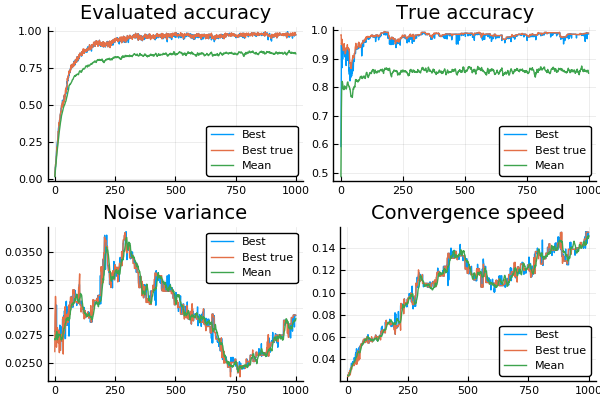

In [6]:
cf = () -> cc(Resamp(10, candbase())) # Resample fitness 10 times.
ga(population_size, num_generations, seed, cfun=cf)

As expected, this improved things dramatically and put us back on track.

One way to apply the above strategy in the context of what NaiveGAflux is doing is to apply some averaging between generations. This has the adverse effect that improvements to the accuracy will also be averaged. Since every model is treated the same way this should not have a too strong negative impact on the search as a model which improves more than some other model will see a bigger bump in fitness.

Lets try with simple moving average over a fixed window of generations:

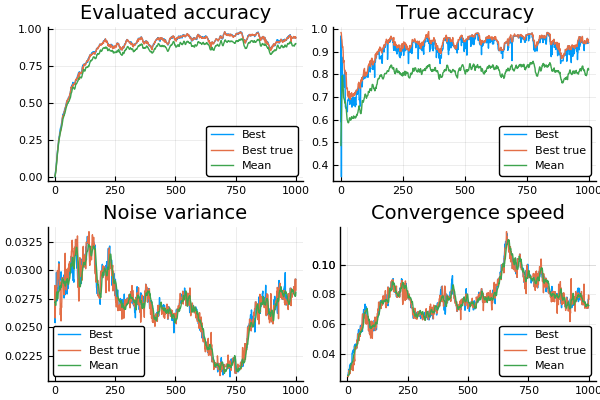

In [7]:
cf = () -> cc(Ma(zeros(10), candbase())) # Average fitness over 10 generations.
ga(population_size, num_generations, seed, cfun=cf)

The strategy seems to have worked! It does not seem to be as effective as the resampling, but this is understandable given that it can be seen as an approximization of the resampling scheme.

Lets try with EWMA (Exponentially Weighted Moving Average) to get an infinite window length while giving more weight to new samples:

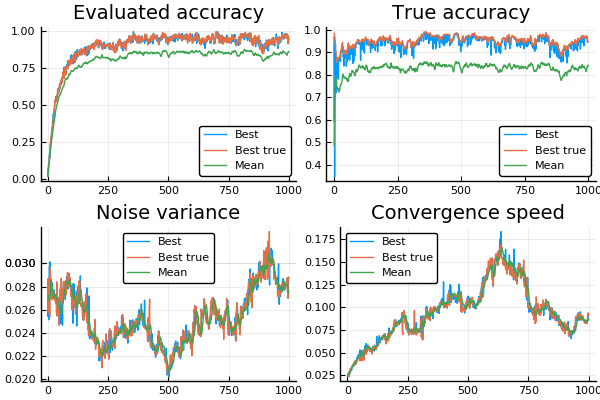

In [8]:
cf = () -> cc(EwmaCand(α = 0.5, c=candbase())) # Roughly 10 samples before past samples are completely forgotten.
ga(population_size, num_generations, seed, cfun=cf)

That seems to work out too!

Is it possible to do better. Lets examine some simple non-linear alternatives.

Start with the strategy to punish candidates who degrade their fitness by training in hopes that this shall reduce the noise:

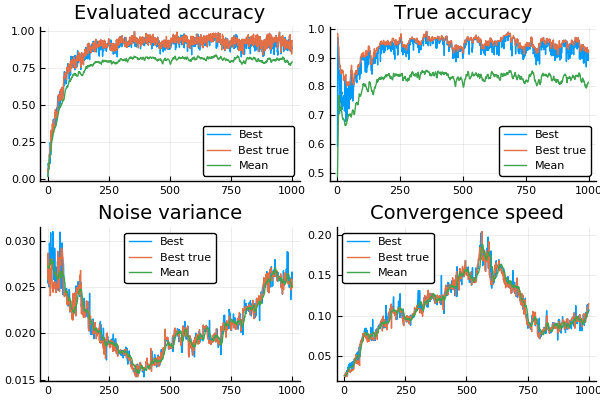

In [9]:
cf = () -> cc(LowBar(candbase()))
ga(population_size, num_generations, seed, cfun=cf)

This did not seem to be as effective as just averaging the fitness. What if we combine it with averaging...

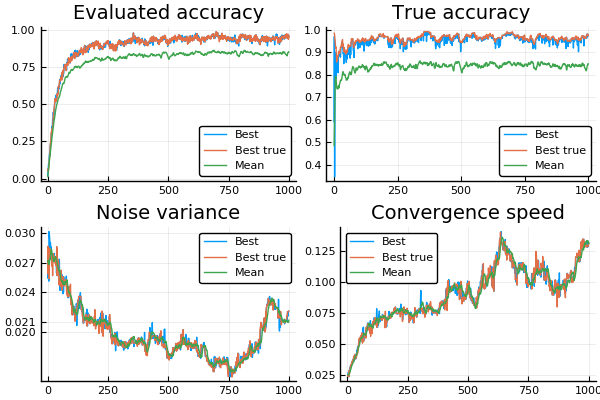

In [10]:
cf = () -> cc(EwmaCand(α = 0.5, c = LowBar(candbase())))
ga(population_size, num_generations, seed, cfun=cf)

Looks like a modest improvement over just applying EWMA. Filtering an already filtered sequence does not really have much of an effect if the first filter is already removing most of the noise. What about if the order is reversed?

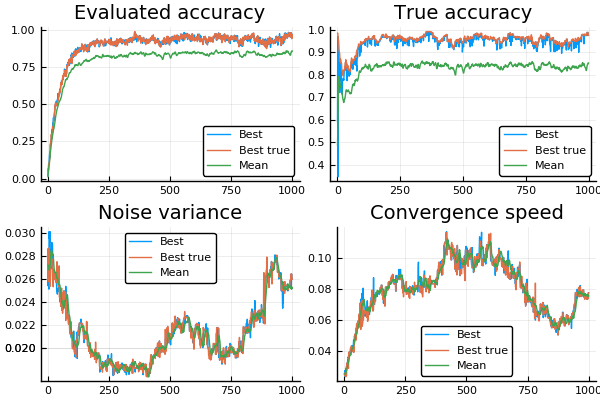

In [11]:
cf = () -> cc(LowBar(EwmaCand(α = 0.5, c = candbase())))
ga(population_size, num_generations, seed, cfun=cf)

Does not really seem to matter alot.

Lets try one more strategy. What happens if we don't allow the fitness to decrease, only increase?

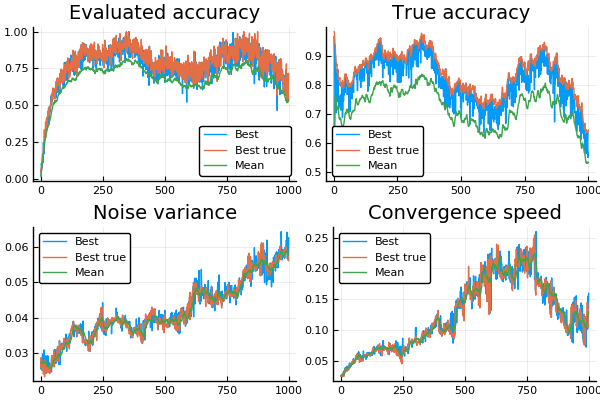

In [12]:
import FitnessNoise.HighBar
cf = () -> cc(HighBar(candbase()))
ga(population_size, num_generations, seed, cfun=cf)

Nothing positive. Probably just makes chasing the highest noise peaks an even more attractive strategy. Lets just try it with averaging just in case...

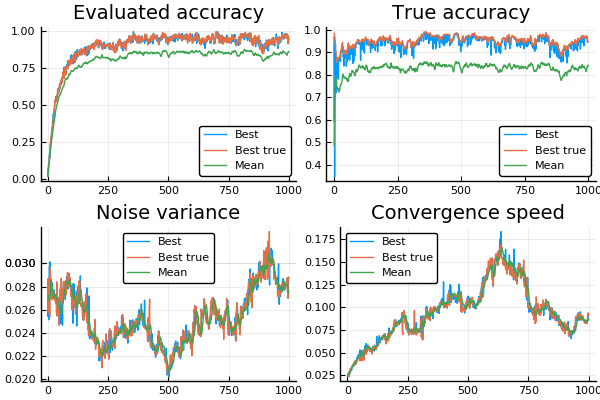

In [13]:
cf = () -> cc(HighBar(EwmaCand(α = 0.5, c = candbase())))
ga(population_size, num_generations, seed, cfun=cf)

Does not seem to bring any improvements over just EWMA.

Lets try one more thing: The how much filtering to apply is a hyperparameter. What if we also try to mutate it so that we search for the best setting. There is obviously a decent chance that the genetic algorithm just learns to game it, but lets try it anyways.

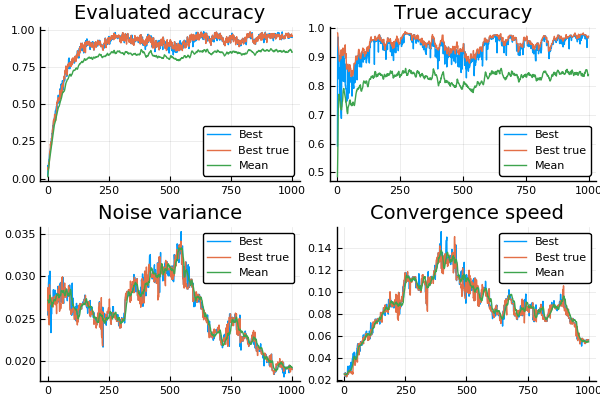

In [14]:
cf = () -> cc(Mutating(EwmaCand(α = 0.5, c = candbase())))
ga(population_size, num_generations, seed, cfun=cf)

Hmm, perhaps I need to tune the mutation hyperparameters for the filtering constant, and maybe mutate those too. Ok, I'll stop this madness now.

Drawing any conclusions from the above set of examples is not easy. For some other random initialization one could end up getting better results. Lets run the above experiments for a large number of random seeds and plot the empirical distribution of the accuarcy for a set of mitigations. 

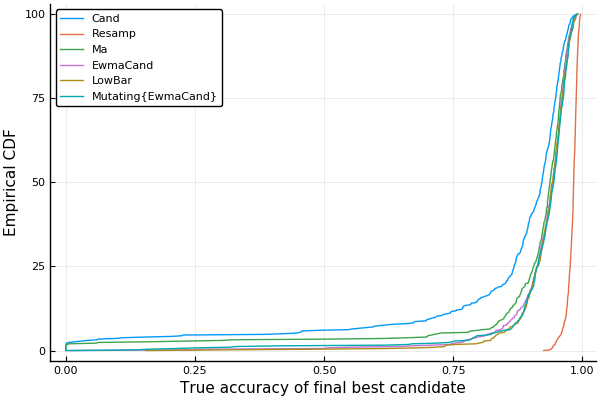

In [15]:
baseline = candbase;
resamp = () -> Resamp(10, candbase());
ma = () -> Ma(zeros(10), candbase());
ewma = () -> EwmaCand(α = 0.5, c = candbase());
ewmalowbar = () -> LowBar(ewma()); 
mewma = () -> Mutating(ewma());

alts = (cc ∘ alt for alt in (baseline, resamp, ma, ewma, ewmalowbar, mewma));
#Ok, now I kinda wish I had paid more attention to performance...

num_seeds = 500
gastat(population_size, num_generations, num_seeds, fs=alts)

Except for the non-applicable strategy to resample, it's basically a wash between the tested strategies with the exception of moving average which seems to be a bit worse than the others. Given its simplicity, the EWMA-strategy is what ended up in NaiveGAflux for now. Please suggest other strategies if you have them, preferably with an update to this notebook :)